# Exploratatory Quick analysis

This data set is meant to fuel a quick (~1 hour) analysis of what I can find in the data.  Specifically, only the columns date and car.count are relavent.  The data are synthetic. I'll try and comment on what I find as I go for notes for discussion over this project.

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import datetime
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.figure(figsize=(12, 10))

### Initial processing
Read in the data, take a look at the two columns of interest (since we're only using two, should we extract into two vectors for ease of use?).

Probably going to keep with the dataframe since that's how I would do it typically.


In [30]:
df = pd.read_csv('data.csv', parse_dates=['date'], dtype={'car.count':np.float64})

The parse_dates makes sure that we get the date colun in datetime format (which makes some plotting and aggregating statistics easier).

### See what's in this file

In [31]:
df.head()

,date,day.of.week,car.count,weather
0,2010-01-01,friday,94.5,-0.1
1,2010-01-02,saturday,108.4,-2.4
2,2010-01-03,sunday,105.5,-0.5
3,2010-01-04,monday,109.6,-2.1
4,2010-01-05,tuesday,116.1,1.9


In [32]:
df.describe()

,car.count,weather
count,1799.000000,1826.000000
mean,171.297387,0.003395
std,34.716283,1.030690
min,50.900000,-3.400000
25%,147.550000,-0.700000
50%,174.700000,0.000000
75%,196.550000,0.700000
max,276.500000,3.600000


It looks like this file is car counts (probably in parking lots) given weather conditions and date (with day of the week provided). For this exercise, we only care about date and car count, so let's see how those correlate.

Also, it looks like there are days without car counts. Between 2010-2014, there should be 365x5 +1 (for the leap year) = 1826, so it appears that each day is represented in the table. We just need to figure out what to do with missing data.  

Options : 
* fill in with mean
* ignore those days (but this could make time-series analysis difficult later)
* average nearest values

In [33]:
# For now, I'm going to fill in missing data with the mean of that month. This should preserve large scale trends. Question 
# is how it will treat short term trends.
def groupMean(group):
    """Takes a group (from pandas groupby) and finds the mean."""
    group.loc[:,'car.count'] = group['car.count'].fillna(group['car.count'].mean())
    return group

# Apply the groupMean function to the dataframe
df = df.groupby([df.date.dt.year, df.date.dt.month]).transform(groupMean)

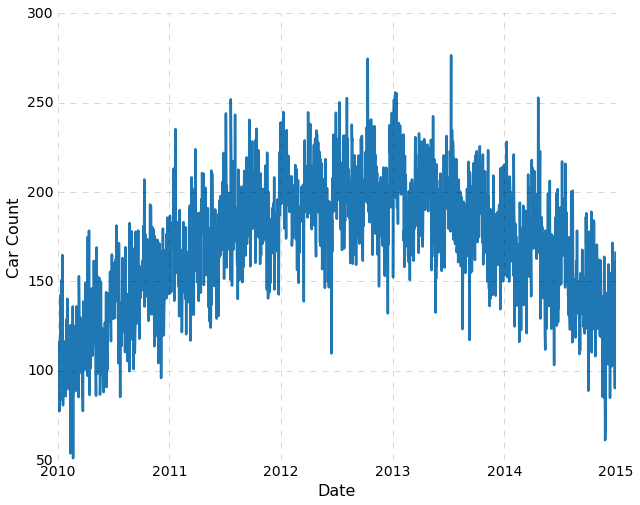

In [38]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(df['date'], df['car.count'])
ax.set_xlim('2010-01-01','2015-01-01')
ax.set_xlabel("Date")
ax.set_ylabel("Car Count")


### Initial Impressions:

There appear to be at least two components to the trend of car counts as a function of date. The first is an overall (longterm) trend that *at first glance* is quadratic-ish. There is clearly structure on smaller scales.  To model this we clearly will need a combination of models (possibly a cyclic + baseline or a linear combination of cyclic functions).  Seeing how we see periodic terms on small scales, we probably don't want to assume that the large scale term is not also periodic, just on scales larger than our time frame.

### Let's take a closer look and see if we can make sense of the higher frequency term.

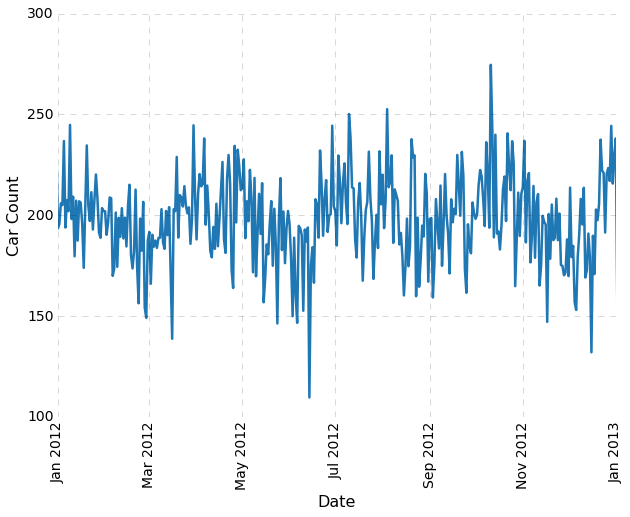

In [40]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(df['date'], df['car.count'])
ax.set_xlim('2012-01-01','2013-01-01')
ax.set_ylim(100, 300)
ax.set_xlabel("Date")
ax.set_ylabel("Car Count")
fig.autofmt_xdate(rotation=90, ha='center')

Looking at this year-long slice of the data, my eye is drawn to a ~3 month period oscilation.  It's hard to tell visually if the "noise" between those terms is really noise or even higher frequency terms.

### A iterative approach. 

Let's remove the obvious trend (using a quadratic for now as we don't have enough information about the large scale trend to remove a periodic term robustly, nor really say it's periodic).

In [41]:
from sklearn.linear_model import LinearRegression

# Not the cleanest way, would rather it be generalized
day = [idx for idx, _ in enumerate(df['date'])]  # Since the df is sorted by date (I checked)
X = np.zeros((len(day), 3))
X[:,0] = 1  # Constant Term
X[:,1] = (day-np.amin(day)) / (np.amax(day)-np.amin(day))   # The day
X[:,2] = np.power(day,2)  # Quadratic Term
X[:,2] = (X[:,2]-np.amin(X[:,2])) / (np.amax(X[:,2])-np.amin(X[:,2]))


In [42]:
model = LinearRegression()
model.fit(X, df['car.count'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

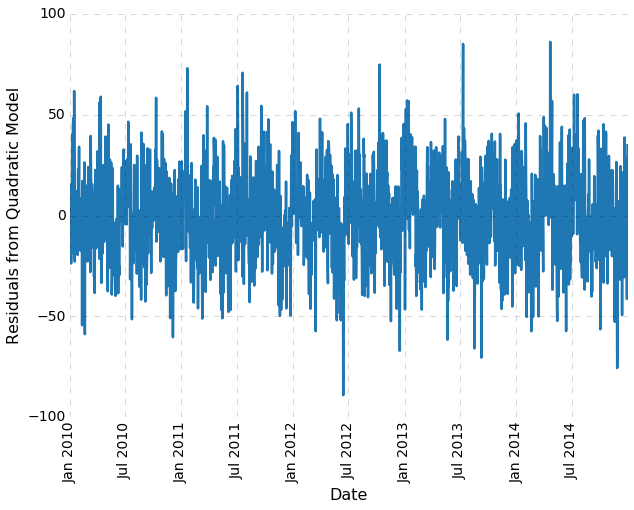

In [46]:
df['residuals'] = df['car.count'] - model.predict(X)

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(df['date'], df['residuals'])
plt.xlabel("Date")
plt.ylabel("Residuals from Quadratic Model")
fig.autofmt_xdate(rotation=90, ha='center')

There's clearly some structure there!  It looks to be periodic, so we should identify the frequency and then we can fit it with a sin wave (or explicity a linear combination of sin+cos to make it linear).

Maximum Frequency Found at 0.010953 1/days
Corresponding to a Period of 91.300000 days
Which is approximately 3.043333 months


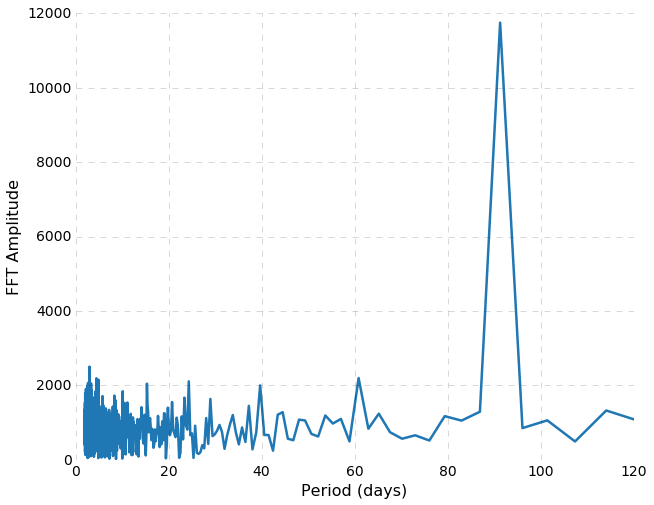

In [51]:
# Do an FFT of the residuals to see what frequencies dominate
y = df['car.count'] - model.predict(X)
fft = np.fft.fft(y)
freq = np.fft.fftfreq(np.array(day).shape[-1])

# We only care about the first half of the terms
freq = freq[0:len(y)/2]
fft = fft[0:len(y)/2]

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(1.0/freq, np.abs(fft))  # Plot in 1/freq to see days/cycle
ax.set_xlim(0, 120)
ax.set_xlabel("Period (days)")
ax.set_ylabel("FFT Amplitude")

(maxfreq, maxamp) = max(zip(freq, np.abs(fft)), key=lambda x: x[1])

maxperiod = 1/maxfreq 
maxmonths = maxperiod / 30

print("Maximum Frequency Found at %f 1/days" % maxfreq)
print("Corresponding to a Period of %f days" % maxperiod)
print("Which is approximately %f months" % maxmonths)

Now, let's redo the linear regression including two periodic terms as well. (sin and cos)

In [52]:
# Not the cleanest way, would rather it be generalized
day = np.array([float(idx) for idx, _ in enumerate(df['date'])])  # Since the df is sorted by date (I checked)

X = np.zeros((len(day), 5))
X[:,0] = 1  # Constant Term
X[:,1] = (day-np.amin(day)) / (np.amax(day)-np.amin(day))   # The day
X[:,2] = np.power(day,2)  # Quadratic Term
X[:,2] = (X[:,2]-np.amin(X[:,2])) / (np.amax(X[:,2])-np.amin(X[:,2])) # Scale to between 0 and 1
X[:,3] = np.sin(2*np.pi*maxfreq*day)  # Sin term
X[:,4] = np.cos(2*np.pi*maxfreq*day)  # Cos Term


In [53]:
# Retrain the model
model = LinearRegression()
model.fit(X, df['car.count'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

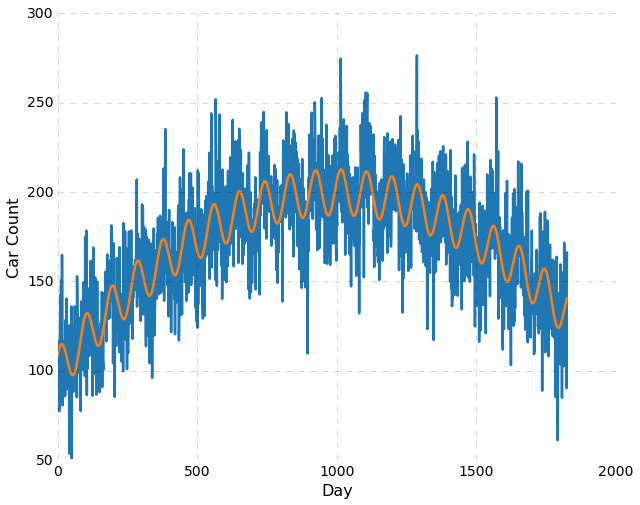

In [55]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(day, df['car.count'])
ax.plot(day, model.predict(X))
ax.set_xlabel("Day")
ax.set_ylabel("Car Count")

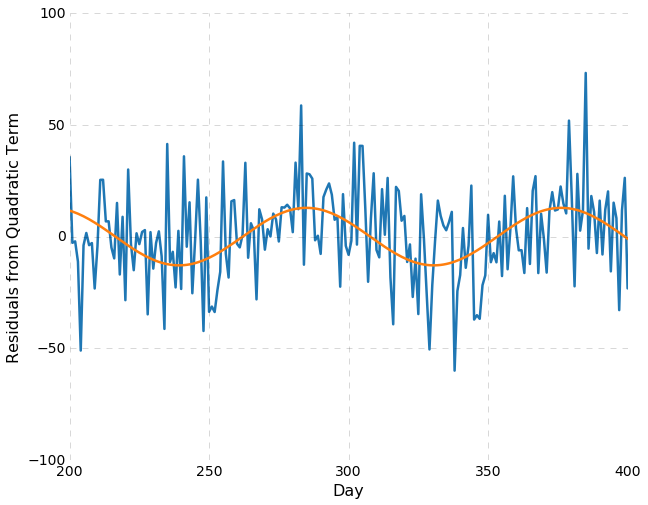

In [66]:
# Look at the residuals to see this better.
X_sub = X.copy()
X_sub[:,3] = 0.0
X_sub[:,4] = 0.0
X_period = X.copy()
for ii in [0, 1, 2]:
    X_period[:,ii] = 0.0
    
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(day, df['car.count']-model.predict(X_sub))
plt.plot(day, model.predict(X)-model.predict(X_sub))
ax.set_xlim(200, 400)
ax.set_xlabel("Day")
ax.set_ylabel("Residuals from Quadratic Term")


(-80, 80)

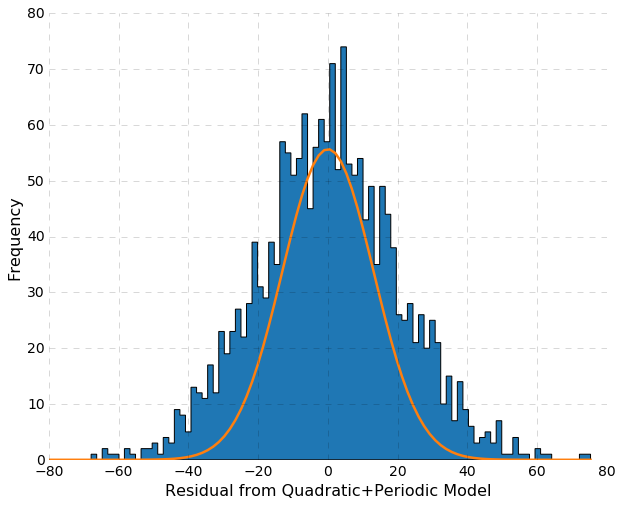

In [71]:
fig, ax = plt.subplots(figsize=(10,8))

residuals = df['car.count']-model.predict(X)
df['residuals'] = residuals
mean_count = df['car.count'].mean()
expected_sigma = np.sqrt(mean_count)
_, bins, _ = plt.hist(residuals, 100, histtype='stepfilled')
gg = scipy.stats.norm.pdf(bins, loc=0, scale=expected_sigma)*len(df)
plt.plot(bins, gg)

plt.xlabel("Residual from Quadratic+Periodic Model")
plt.ylabel("Frequency")
plt.xlim(-80, 80)

The final distribution isn't far from gaussian and is pretty close to what we might expect for a distribution with a dispersion given by the mean number of cars we see on a given day. 

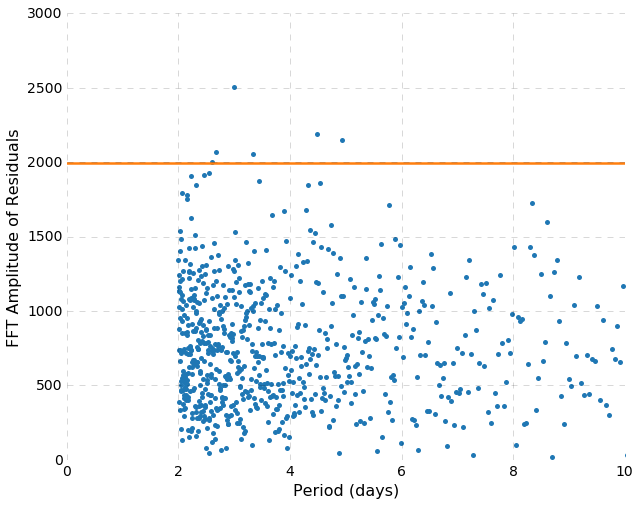

In [73]:
fig, ax = plt.subplots(figsize=(10,8))
y = df['residuals']
# Do an FFT of the residuals to see what frequencies dominate
fft = np.fft.fft(y)
freq = np.fft.fftfreq(np.array(day).shape[-1])

# We only care about the first half of the terms
freq = freq[0:len(y)/2]
fft = fft[0:len(y)/2]

mean = np.mean(np.abs(fft))
std = np.std(np.abs(fft))

plt.plot(1/freq, np.abs(fft), '.')  # Plot in 1/freq to see days/cycle
plt.plot([0, 555], [mean+3.0*std]*2)
plt.xlim(0, 10)
plt.xlabel("Period (days)")
plt.ylabel("FFT Amplitude of Residuals")

The peaks here are marginal at best. Given that the noise in the FFT is correlated, a 3-sigma threshold is likely being far too lenient.  We could imagine in a situation with more time to look at this, we could fit each of these frequencies and include some form of regularlization and then do feature selection based on that.

In [74]:
# Calculate the transformation from A sin x + B cos x to A' sin(x + beta)
beta = np.arctan(model.coef_[4]/model.coef_[3])
amplitude = model.coef_[4]/np.sin(beta)

# Quantitative Findings:

The car count is controled by two components.  The first is a long-time-baseline quadratic
dependence.  

The form of this mode is (where D is the number of days since Jan 1, 2010):


<latex>
base = $366.10D - 334.08D^2 = 366.1D(1-0.94D)$
</latex>


On top of ths quadratic term, there is a periodic oscilation with a period of 91.3 days (approximately 3 months).  

We find:

<latex>
periodic = $8.23 \mbox{sin}(2*\pi*\frac{D}{91.3}) + 9.38 \mbox{cos}(2*\pi*\frac{D}{91.3})$
</latex>

using trigonometric identities, we can change this to :

<latex>
periodic = $12.88 \mbox{sin}(2*\pi*\frac{D}{91.3} + 0.8157)$
</latex>

In words, the car counts vary by 13 cars in a period way with a period of 91.3 days.  

# Some ideas for further analysis:

1. Better exploration of the FFT parameter space.  There are some frequencies there that *might* be important, but through both lack of time and concern of introducting overfitting, I didn't pursue fitting them for this exercise.  Including them in a regularized linear regression and then studying the size of the regularlized coefficients can give us some idea of those were signficant.

2. Estimate errors on the model parameters.  Either through Monte Carlo exploration of the parameter space, bootstrapping the data (though I've not done this with time series data and there are definitely some possible gotchas to this, especially when doing the FFTs.  If we were satisfied we had identified all potential frequencies, we could study how bootstrapping affects the model parameters without this concern.

3. We only used 2 columns of the table, so extending to the other two columns and looking at how day of the week and weather. affects the car counts.

4. If we know the details about the car counts, we could look for external data to try and correlate with the trends we're seeing.  If the car counts are in parking lots,  we might expect the baseline trend to be associated with various economy indicators which would allow us to make a predictive model based on current economic indicators to predict parking lot counts. Right now, our model, in order to predict something in the future, will have to just extrapolate the last trends, which can be dangerous as it removes our knowledge of possible important features.

5. Similarly, the 91 day oscilation is a very strong feature in this data, so having a "real-life" mechanism for this will be helpful in making a robust predictive model.  For example, if we find that a given department store has seasonal sales every six months or focuses their advertising every three months, and that correlates with the oscilations we see here, we would then have a feature we can follow in future predictive models (in the event the company changes their marketing strategy, for example).  